In [1]:
from tqdm import tqdm
import os
from copy import deepcopy
import pickle
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from datasets.ascad_datasets import AscadDataset, RandomShift, RandomNoise
from models.resnet_1d import resnet18
from models.cnn import EffNetDS50
from training.single_model import train_step, eval_step
from training.common import execute_epoch
from display_results import plot_traces

In [2]:
model = EffNetDS50((1, 700), (256,), width_multiplier=10)
print(model)

EffNetDS50(
  (feature_extractor): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
    (2): SELU()
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (5): Conv1d(32, 64, kernel_size=(25,), stride=(1,), padding=(12,))
    (6): SELU()
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AvgPool1d(kernel_size=(25,), stride=(25,), padding=(0,))
    (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): SELU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  )
  (fc): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=384, out_features=150, bias=True)
    (2): SELU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_feature

In [3]:
epochs_per_trial = 100
device = 'cuda'
results_path = os.path.join('.', 'results', 'disc_hparam_sweep')

#hparams_to_sweep = {
#    'dataset_kwargs': [
#        {'transform': RandomShift(), 'traces_per_sample': val} for val in range(1, 3)
#    ]
#}

hparams_to_sweep = {
    'width_multiplier': [2, 4, 8, 16, 32, 64],
    'dataset_kwargs': [
        {'transform': RandomShift(max_shift_size=n)} for n in range(1, 51, 10)
    ] + [
        {'transform': Compose((RandomShift(), RandomNoise(max_convex_coef=x)))} for x in np.logspace(-2, 0, 20)
    ] + [
        {'transform': RandomShift(), 'mixup': True}
    ],
    'input_dropout': [1e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    'dropout': [1e-3, 1e-2, 5e-2, 1e-1, 5e-1],
    'batch_size': [64, 128, 256, 512, 1024]
}

#hparams_to_sweep = {
#    'dataset_kwargs': [
#        #{'transform': RandomShift(max_shift_size=0), 'mixup': False},
#        {'transform': RandomShift(), 'mixup': False},
#        {'transform': Compose((RandomShift(max_shift_size=0), RandomNoise())), 'mixup': False},
#        {'transform': RandomShift(max_shift_size=0), 'mixup': True},
#        {'transform': Compose((RandomShift(), RandomNoise())), 'mixup': False},
#        {'transform': RandomShift(), 'mixup': True},
#        {'transform': Compose((RandomShift(max_shift_size=0), RandomNoise())), 'mixup': True},
#        {'transform': Compose((RandomShift(), RandomNoise())), 'mixup': True}
#    ]
#}

#hparams_to_sweep = {
#    'learning_rate': [1e-3, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
#    'weight_decay': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
#    'dropout': [0, 1e-3, 1e-2, 1e-1, 5e-1],
#    'batch_size': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}

In [4]:
#class LossFn:
#    def __init__(self):
#        self.bce_loss = nn.BCELoss()
#    def __call__(self, logits, target):
#        prediction = nn.functional.softmax(logits, dim=-1)
#        if target.shape != prediction.shape:
#            target = nn.functional.one_hot(target, num_classes=256).to(torch.float)
#        loss = self.bce_loss(prediction, target)
#        return loss

LossFn = nn.CrossEntropyLoss
from torch.optim.lr_scheduler import OneCycleLR as LRScheduler

Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:05<00:00, 13.20s/it]

Done. Min rank: 85.64900000000002
	New best min rank. Previous best: inf


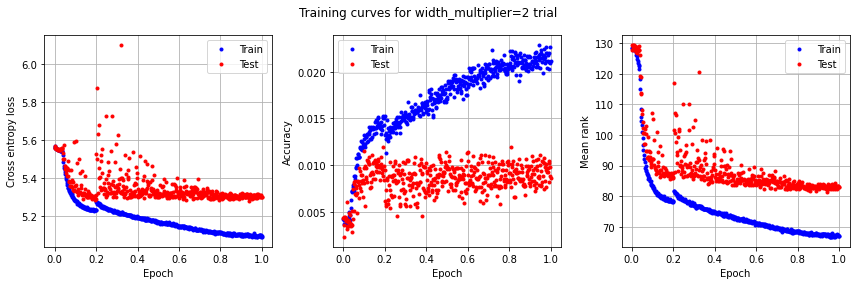







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:07<00:00, 13.15s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 38/101 [08:15<13:54, 13.25s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 77/101 [16:50<05:16, 13.19s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:08<00:00, 13.26s/it]

Done. Min rank: 85.63119999999999
	New best min rank. Previous best: 85.64900000000002


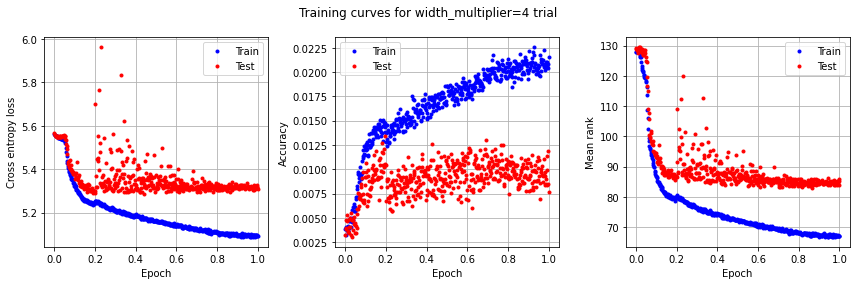







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:11<00:00, 13.33s/it]

Done. Min rank: 86.0683


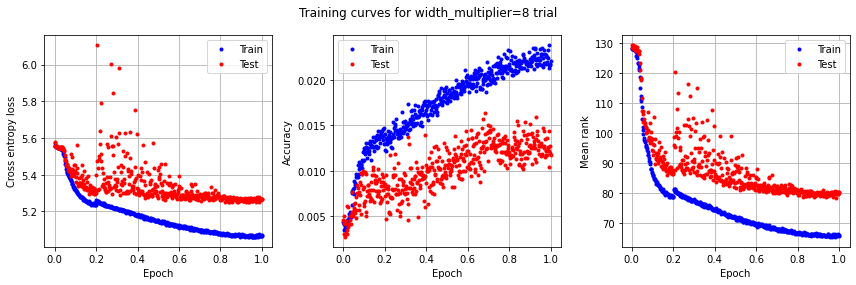







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:13<00:00, 13.20s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 38/101 [08:17<13:52, 13.22s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 77/101 [16:52<05:17, 13.21s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:10<00:00, 13.23s/it]

Done. Min rank: 84.5763
	New best min rank. Previous best: 85.63119999999999


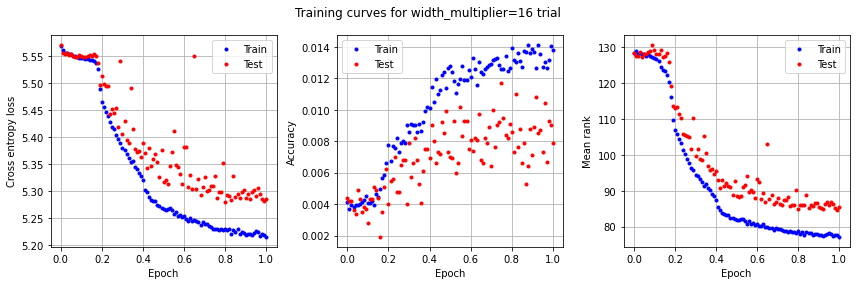







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:11<00:00, 13.25s/it]

Done. Min rank: 84.2366
	New best min rank. Previous best: 84.5763


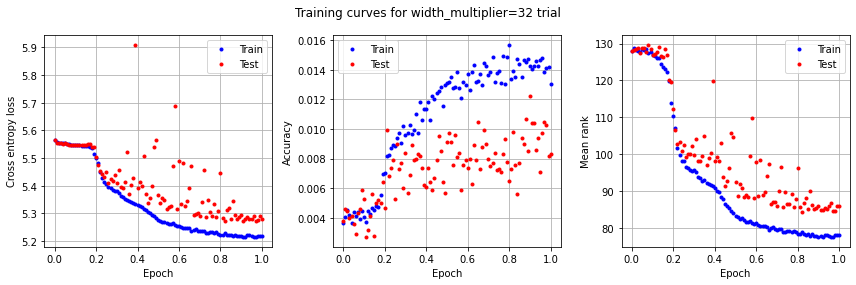







Starting new width_multiplier trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:12<00:00, 13.19s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 38/101 [08:16<13:53, 13.23s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 77/101 [16:52<05:17, 13.22s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:09<00:00, 13.20s/it]

Done. Min rank: 88.3768


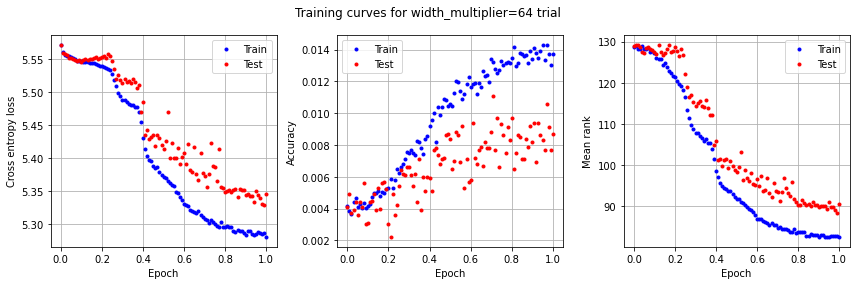







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:12<00:00, 13.26s/it]

Done. Min rank: 91.10490000000001
	New best min rank. Previous best: inf


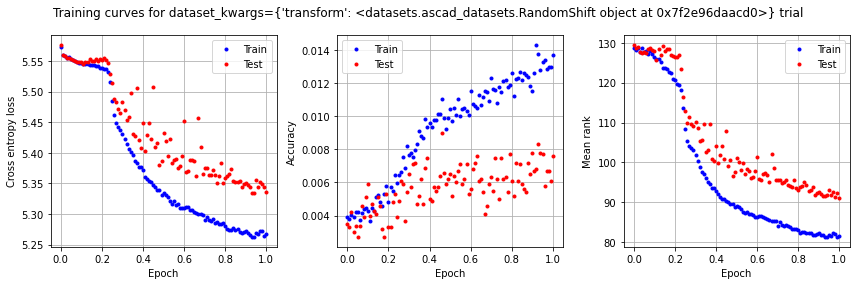







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:13<00:00, 13.20s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 38/101 [08:17<13:52, 13.22s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 77/101 [16:55<05:18, 13.27s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:13<00:00, 13.27s/it]

Done. Min rank: 94.2903


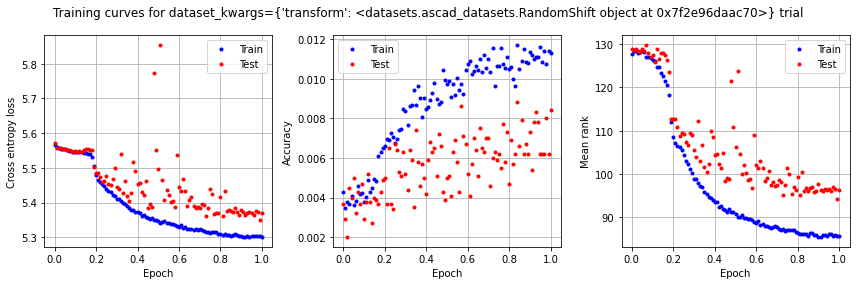







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:12<00:00, 13.29s/it]

Done. Min rank: 88.495
	New best min rank. Previous best: 91.10490000000001


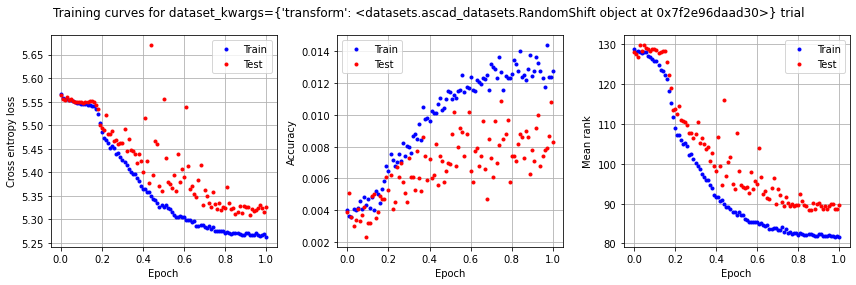







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:13<00:00, 13.20s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 38/101 [08:17<13:56, 13.28s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 77/101 [16:55<05:17, 13.22s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:13<00:00, 13.28s/it]

Done. Min rank: 90.58609999999999


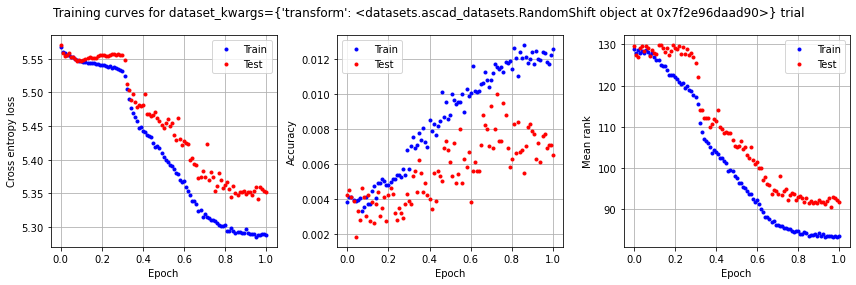







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:12<00:00, 13.25s/it]

Done. Min rank: 95.272


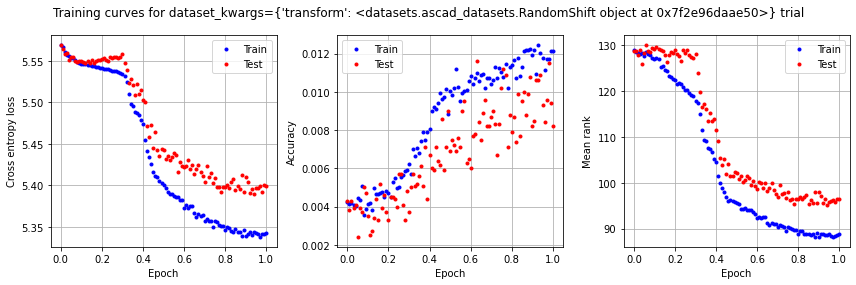







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [22:13<00:00, 13.21s/it]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 38/101 [10:02<16:49, 16.02s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 77/101 [20:28<06:24, 16.03s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [26:52<00:00, 15.99s/it]

Done. Min rank: 126.7891


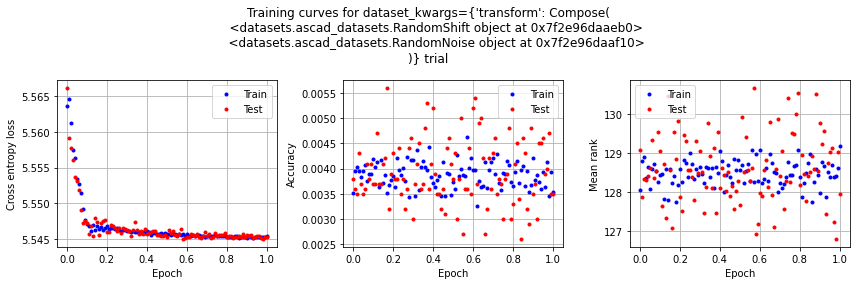







Starting new dataset_kwargs trial...
	Learning rate: 1e-05
	Weight decay: 0
	Dropout: 0.0
	
	Batch size: 100


 10%|████████████████▋                                                                                                                                                       | 10/101 [02:33<24:05, 15.89s/it]

In [ ]:
default_lr = 1e-5
default_width_multiplier = 1
default_weight_decay = 0
default_dropout = 0.
default_input_dropout = 0.
default_batch_size = 100
default_dataset_kwargs = {'transform': RandomShift()}

for hparam_name, values_to_try in hparams_to_sweep.items():
    best_min_rank = np.inf
    for value in values_to_try:
        min_rank = np.inf
        if hparam_name == 'learning_rate':
            learning_rate = value
        else:
            learning_rate = default_lr
        if hparam_name == 'weight_decay':
            weight_decay = value
        else:
            weight_decay = default_weight_decay
        if hparam_name == 'dropout':
            dropout = value
        else:
            dropout = default_dropout
        if hparam_name == 'input_dropout':
            input_dropout = value
        else:
            input_dropout = default_input_dropout
        if hparam_name == 'batch_size':
            batch_size = value
        else:
            batch_size = default_batch_size
        if hparam_name == 'dataset_kwargs':
            dataset_kwargs = value
        else:
            dataset_kwargs = default_dataset_kwargs
        if hparam_name == 'width_multiplier':
            width_multiplier = value
        else:
            width_multiplier = default_width_multiplier
        print('Starting new {} trial...'.format(hparam_name))
        print('\tLearning rate: {}'.format(learning_rate))
        print('\tWeight decay: {}'.format(weight_decay))
        print('\tDropout: {}'.format(dropout))
        print('\t')
        print('\tBatch size: {}'.format(batch_size))
        if 'traces_per_sample' in dataset_kwargs:
            traces_per_sample = dataset_kwargs['traces_per_sample']
        else:
            traces_per_sample = 1
        train_dataset = AscadDataset(train=True, **dataset_kwargs)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = AscadDataset(train=False, transform=RandomShift(max_shift_size=0), traces_per_sample=traces_per_sample)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
        model = EffNetDS50((traces_per_sample, 700), (256,), width_multiplier=traces_per_sample, dropout=dropout, input_dropout=input_dropout).to(device) #resnet18(dropout=dropout).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = LRScheduler(optimizer, 1e-3, pct_start=0.2, cycle_momentum=False, epochs=epochs_per_trial, steps_per_epoch=len(train_dataloader))
        loss_fn = LossFn()
        
        def train_epoch(idx, train=True):
            if train:
                results = execute_epoch(train_step, train_dataloader,
                                        model, loss_fn, optimizer, device, callback=lr_scheduler.step)
            else:
                results = execute_epoch(eval_step, train_dataloader,
                                        model, loss_fn, device)
            with open(os.path.join(results_path, 'hparam_{}_val_{}__train_epoch_{}.pickle'.format(hparam_name, value, idx)), 'wb') as F:
                pickle.dump(results, F)
        def eval_epoch(idx):
            global min_rank
            results = execute_epoch(eval_step, test_dataloader,
                                    model, loss_fn, device)
            rank = np.mean(results['mean_rank'])
            if rank < min_rank:
                min_rank = rank
            with open(os.path.join(results_path, 'hparam_{}_val_{}__eval_epoch_{}.pickle'.format(hparam_name, value, idx)), 'wb') as F:
                pickle.dump(results, F)
        
        progress_bar = tqdm(total=epochs_per_trial+1)
        train_epoch(0, train=False)
        eval_epoch(0)
        progress_bar.update(1)
        for epoch in range(1, epochs_per_trial+1):
            train_epoch(epoch)
            eval_epoch(epoch)
            progress_bar.update(1)
        print('Done. Min rank: {}'.format(min_rank))
        
        if min_rank < best_min_rank:
            print('\tNew best min rank. Previous best: {}'.format(best_min_rank))
            best_min_rank = min_rank
            if hparam_name == 'learning_rate':
                default_lr = value
            elif hparam_name == 'weight_decay':
                default_weight_decay = value
            elif hparam_name == 'dropout':
                default_dropout = value
            elif hparam_name == 'input_dropout':
                default_input_dropout = value
            elif hparam_name == 'batch_size':
                default_batch_size = value
            elif hparam_name == 'dataset_kwargs':
                default_dataset_kwargs = value
            elif hparam_name == 'width_multiplier':
                default_width_multiplier = value
        
        fig, axes = plot_traces(results_path, 'hparam_{}_val_{}'.format(hparam_name, value), ['loss', 'acc', 'mean_rank'], average_over_epoch=True)
        axes[0].set_ylabel('Cross entropy loss')
        axes[1].set_ylabel('Accuracy')
        axes[2].set_ylabel('Mean rank')
        fig.suptitle('Training curves for {}={} trial'.format(hparam_name, value))
        plt.tight_layout()
        plt.show()
        print('\n\n\n\n\n')